# Initialiazation Packages

In [1]:
#using Pkg; Pkg.build("PyCall")
#using Pkg; Pkg.build("PyPlot")
#using PyCall
#PyCall.python
using PyCall
using PyPlot

In [2]:
using LinearAlgebra
using LaTeXStrings
using QuantumToolbox
using DelimitedFiles, NLsolve
using Random, Distributions, Dates, Polynomials, StatsBase 
using JLD

In [43]:
#using Pkg
#Pkg.activate("..")

include("../src/Classical_open_2KPOs_functions.jl")
using .Classical_open_KPOs

## Fixed points analysis for the open coupled KPOs

### Nomenclature for the fixed points:

Given a fixed point $\bold{x}_i$, we classifiy it accordignly to the Jacobian matrix eigenvalues $\bold{\lambda}_i$. For the coupled KPOs we have 4 eigenvalues following the classification

1. If all $\lambda_i$ have $Re(\lambda_i) = 0$ and $Re(\lambda_i) \neq 0$, **Circle fixed point (Stable)**
2. If all $\lambda_i$ have $Re(\lambda_i) \neq 0$ (half positive half negative) and $Re(\lambda_i) = 0$, **Saddle point (Unstable)**
3. If all $\lambda_i$ have $Re(\lambda_i) < 0$ and $Re(\lambda_i) = 0$, **Stable node point (Stable)**
4. If all $\lambda_i$ have $Re(\lambda_i) > 0$ and $Re(\lambda_i) = 0$, **Unstable node point (Unstable)**
5. If 2 $\lambda_i$ have $Re(\lambda_i) \neq 0$ and $Re(\lambda_i) = 0$ and 2 $\lambda_i$ have $Re(\lambda_i) = 0$ and $Re(\lambda_i) \neq 0$, **Saddle-center point (Unstable)**
6. if all $\lambda_i$ have $Re(\lambda_i) < 0$ and $Im(\lambda_i) \neq 0$, **Spiral spink fixed point (Stable)** 
7. if all $\lambda_i$ have $Re(\lambda_i) > 0$ and $Im(\lambda_i) \neq 0$, **Spiral sourse fixed point (Stable)** 

In [12]:
N_p = 100; # Number of sweeping parameter
κ_min, κ_max = 0.1, 40
ps = range( κ_min,  κ_max, length = N_p); #range of the sweeping parameter 
θ1s = fill(NaN, N_p, 12); # angles
s_λs = fill("", N_p, 12); # stability labels
λs = [zeros(ComplexF64, 2,2)] #List of the eigenvalues
Rs = zeros(N_p); # number of roots
All_roots = [];
p = Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, γ  = 0., 1., 0., 5., 0., 1., 0., 5., 1.0;

In [13]:
for j in 1:N_p
    #KPOs parameters
    parameters = Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, γ, ps[j], ps[j];

    roots_, λ, s_λ = Classical_open_KPOs.crit_energies(parameters, 6);

    R = length(roots_)
    Rs[j] = R
    θ1= zeros(R)
    #println(j)
    
    for i in 1:R
        if norm(roots_[i]) > 1e-5
            θ1[i] = atan(roots_[i][3], roots_[i][1])
        else
            θ1[i] = 0
        end
    end

    sorted_indices = sortperm(θ1)
    roots_, λ, s_λ = (roots_[sorted_indices]), λ[sorted_indices,:], s_λ[sorted_indices]

    θ1s[j,1:R] = θ1[sorted_indices]
    s_λs[j,1:R] = s_λ
    if j == 1
        λs[1] = λ
    else
        push!(λs, λ)
    end
    push!(All_roots, roots_)
end

Checking $\lambda$ and labels

In [26]:
n = 1
println("κ = $(ps[n])")
display(θ1s[n,:]')
display(round.(λs[n], digits=4))
display(s_λs[n,:])
#display(log.(λs[n]))

κ = 0.1


1×12 adjoint(::Vector{Float64}) with eltype Float64:
 -2.35619  -1.47012  -0.785398  -0.10068  …  2.35619  3.04091  NaN  NaN  NaN

9×4 Matrix{ComplexF64}:
   -0.05-20.9759im    -0.05+20.9759im   -0.05-22.9779im   -0.05+22.9779im
 -9.9277+0.0im        -0.05-19.8383im   -0.05+19.8383im  9.8277+0.0im
   -0.05-18.9733im    -0.05+18.9733im   -0.05-16.9702im   -0.05+16.9702im
 -9.9277+0.0im        -0.05-19.8383im   -0.05+19.8383im  9.8277+0.0im
 -9.9999+0.0im      -9.9999+0.0im      9.8999+0.0im      9.8999+0.0im
   -0.05-20.9759im    -0.05+20.9759im   -0.05-22.9779im   -0.05+22.9779im
 -9.9277+0.0im        -0.05-19.8383im   -0.05+19.8383im  9.8277+0.0im
   -0.05-18.9733im    -0.05+18.9733im   -0.05-16.9702im   -0.05+16.9702im
 -9.9277+0.0im        -0.05-19.8383im   -0.05+19.8383im  9.8277+0.0im

12-element Vector{String}:
 "Spiral sink"
 "Saddle-spiral"
 "Spiral sink"
 "Saddle-spiral"
 "Saddle"
 "Spiral sink"
 "Saddle-spiral"
 "Spiral sink"
 "Saddle-spiral"
 ""
 ""
 ""

### Bifurcation plot and fixed points 

In [14]:
stb = ["Saddle", "Saddle-spiral", "Center", "Saddle-center", "Spiral source", "Spiral sink", "Unstable node", "Stable node", "Unclassified"]    ;
stb_marker = [">", "x", "*", "o", "s", "^" , "+", "1", "D"];
stb_color = ["magenta", "red",  "green", "orange", "purple", "brown", "blue", "lawngreen", "cyan"];
N_stb = length(stb);

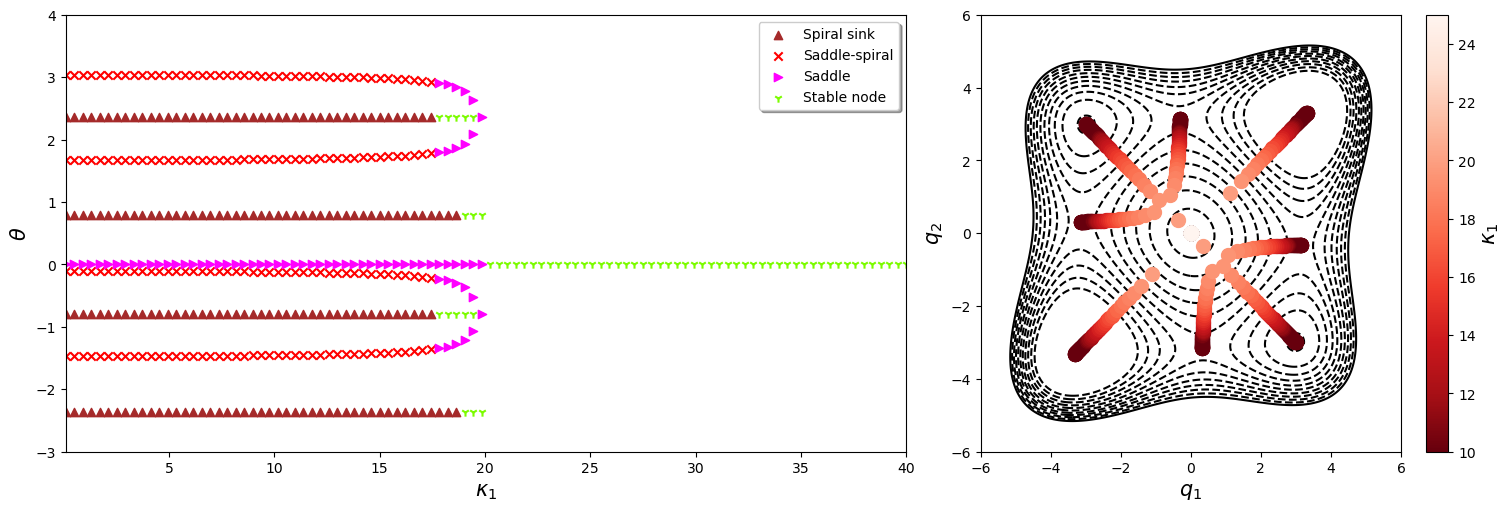

In [23]:
fig = figure(figsize=(15, 5), layout="constrained");
gs = fig.add_gridspec(1,3);
element(i,j) = get(gs, (i,j)); # starts at 0 to N-1
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j);
font_l = 15
font_t = 13
stb_aux = ["Saddle", "Saddle-spiral", "Center", "Saddle-center", "Spiral source", "Spiral sink", "Unstable node", "Stable node", "Unclassified"]    ;


ax = fig.add_subplot(element(0,slice(0,2)));
for i in 1:length(ps)
    num_fp = count(x -> x != "", s_λs[i,:])

    if num_fp == 0
        continue
    end

    for j in 1:num_fp
        idx = findall(x -> x == s_λs[i,:][j], stb)[1]

        if s_λs[i,:][j] in stb_aux
            scatter(ps[i], θ1s[i,:][j], color=stb_color[idx], marker= stb_marker[idx],label= s_λs[i,:][j]);
            filter!(x -> x != s_λs[i,:][j], stb_aux)
            legend(fontsize=10, shadow=true, loc = "upper right");

        else
            scatter(ps[i], θ1s[i,:][j], color=stb_color[idx], marker= stb_marker[idx]);
        end
    end
end
ax.set_xlabel(L"κ_{1}",fontsize=font_l);
ax.set_ylabel(L"θ",fontsize=font_l);
ax.set_xlim(ps[1], ps[end])
ax.set_ylim(-3, 4)
#xscale("log");
#Second option of plot (single color)
ax = fig.add_subplot(element(0,2))
x_lim = 6
x = range(-x_lim,x_lim, length=1000);
y = range(-x_lim,x_lim, length=1000);
#Equivalent of meshgrid
coordinates_x = repeat(x', length(x), 1);
coordinates_y = repeat(y, 1, length(y));

#q1q2
q1, p1, q2, p2 = coordinates_x,0, coordinates_y,0;#q1,q2 
#q1, p1, q2, p2 = coordinates_x, coordinates_y,0.,0. #q1,p1

E_Contours = H_class([q1, p1, q2, p2], p);

Emin, Emax = -40, 0.
CS = contour(coordinates_x, coordinates_y, E_Contours, range(Emin, 2., length = 11), colors="black", zorder = 3);

κ_min, κ_max = 0.1, 40
c_val = range(κ_min, 0, length = N_p)
for i in 1:N_p
    for j in 1:Int(Rs[i])
        scatter(All_roots[i][j][1], All_roots[i][j][3], c = ps[i], vmin=10, vmax=25., cmap ="Reds_r", marker = "o", s=100,zorder = 4)
    end
end
#cbar = colorbar(ticks=[0.7, 0.85, 1])
cbar = colorbar()
cbar.set_label(L"κ_{1}", fontsize=font_l);
#cbar.ax.set_yticklabels([0.1, 0.05, 0.001])
ax.set_xlabel(L"q_{1}",fontsize=font_l);
ax.set_ylabel(L"q_{2}",fontsize=font_l);

In [25]:
N_p = 100; # Number of sweeping parameter
κ_min, κ_max = 15., 23.
ps = range( κ_min,  κ_max, length = N_p); #range of the sweeping parameter 
θ1s = fill(NaN, N_p, 12); # angles
s_λs = fill("", N_p, 12); # stability labels
λs = [zeros(ComplexF64, 2,2)] #List of the eigenvalues
Rs = zeros(N_p); # number of roots
All_roots = [];
p = Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, γ  = 0., 1., 0., 5., 0., 1., 0., 5., 1.0;

for j in 1:N_p
    #println("j = $(j) and κ = $(ps[j])")
    #KPOs parameters
    parameters = Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, γ, ps[j], ps[j];

    roots_, λ, s_λ = Classical_open_KPOs.crit_energies(parameters, 6);

    R = length(roots_)
    Rs[j] = R
    θ1= zeros(R)
    #println(j)
    
    for i in 1:R
        if norm(roots_[i]) > 1e-5
            θ1[i] = atan(roots_[i][3], roots_[i][1])
        else
            θ1[i] = 0
        end
    end

    sorted_indices = sortperm(θ1)
    roots_, λ, s_λ = (roots_[sorted_indices]), λ[sorted_indices,:], s_λ[sorted_indices]

    θ1s[j,1:R] = θ1[sorted_indices]
    s_λs[j,1:R] = s_λ
    if j == 1
        λs[1] = λ
    else
        push!(λs, λ)
    end
    push!(All_roots, roots_)
end

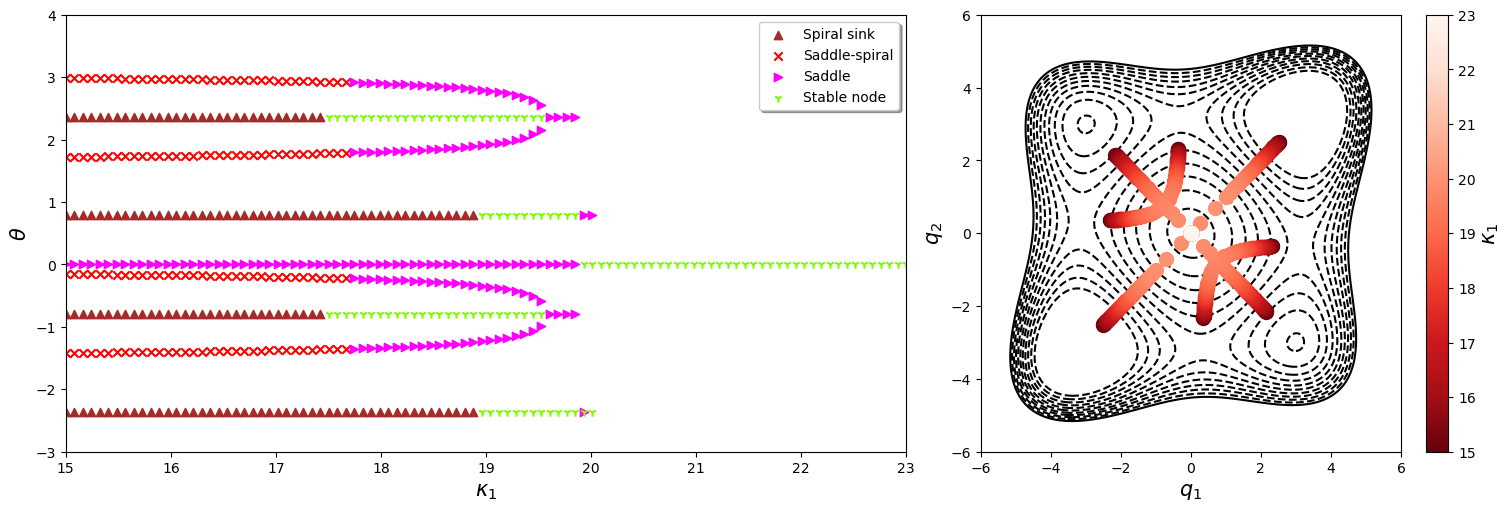

In [27]:
stb = ["Saddle", "Saddle-spiral", "Center", "Saddle-center", "Spiral source", "Spiral sink", "Unstable node", "Stable node", "Unclassified"]    ;
stb_marker = [">", "x", "*", "o", "s", "^" , "+", "1", "D"];
stb_color = ["magenta", "red",  "green", "orange", "purple", "brown", "blue", "lawngreen", "cyan"];
N_stb = length(stb);

fig = figure(figsize=(15, 5), layout="constrained");
gs = fig.add_gridspec(1,3);
element(i,j) = get(gs, (i,j)); # starts at 0 to N-1
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j);
font_l = 15
font_t = 13
stb_aux = ["Saddle", "Saddle-spiral", "Center", "Saddle-center", "Spiral source", "Spiral sink", "Unstable node", "Stable node", "Unclassified"]    ;


ax = fig.add_subplot(element(0,slice(0,2)));
for i in 1:length(ps)
    num_fp = count(x -> x != "", s_λs[i,:])

    if num_fp == 0
        continue
    end

    for j in 1:num_fp
        idx = findall(x -> x == s_λs[i,:][j], stb)[1]

        if s_λs[i,:][j] in stb_aux
            scatter(ps[i], θ1s[i,:][j], color=stb_color[idx], marker= stb_marker[idx],label= s_λs[i,:][j]);
            filter!(x -> x != s_λs[i,:][j], stb_aux)
            legend(fontsize=10, shadow=true, loc = "upper right");

        else
            scatter(ps[i], θ1s[i,:][j], color=stb_color[idx], marker= stb_marker[idx]);
        end
    end
end
ax.set_xlabel(L"κ_{1}",fontsize=font_l);
ax.set_ylabel(L"θ",fontsize=font_l);
ax.set_xlim(ps[1], ps[end])
ax.set_ylim(-3, 4)
#xscale("log");
#Second option of plot (single color)
ax = fig.add_subplot(element(0,2))
x_lim = 6
x = range(-x_lim,x_lim, length=1000);
y = range(-x_lim,x_lim, length=1000);
#Equivalent of meshgrid
coordinates_x = repeat(x', length(x), 1);
coordinates_y = repeat(y, 1, length(y));

#q1q2
q1, p1, q2, p2 = coordinates_x,0, coordinates_y,0;#q1,q2 
#q1, p1, q2, p2 = coordinates_x, coordinates_y,0.,0. #q1,p1

E_Contours = H_class([q1, p1, q2, p2], p);

Emin, Emax = -40, 0.
CS = contour(coordinates_x, coordinates_y, E_Contours, range(Emin, 2., length = 11), colors="black", zorder = 3);

for i in 1:N_p
    for j in 1:Int(Rs[i])
        scatter(All_roots[i][j][1], All_roots[i][j][3], c = ps[i], vmin=κ_min, vmax=κ_max, cmap ="Reds_r", marker = "o", s=100,zorder = 4)
    end
end
#cbar = colorbar(ticks=[0.7, 0.85, 1])
cbar = colorbar()
cbar.set_label(L"κ_{1}", fontsize=font_l);
#cbar.ax.set_yticklabels([0.1, 0.05, 0.001])
ax.set_xlabel(L"q_{1}",fontsize=font_l);
ax.set_ylabel(L"q_{2}",fontsize=font_l);


In [28]:
N_p = 100; # Number of sweeping parameter
κ_min, κ_max = 17., 18.
ps = range( κ_min,  κ_max, length = N_p); #range of the sweeping parameter 
θ1s = fill(NaN, N_p, 12); # angles
s_λs = fill("", N_p, 12); # stability labels
λs = [zeros(ComplexF64, 2,2)] #List of the eigenvalues
Rs = zeros(N_p); # number of roots
All_roots = [];
p = Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, γ  = 0., 1., 0., 5., 0., 1., 0., 5., 1.0;

for j in 1:N_p
    #println("j = $(j) and κ = $(ps[j])")
    #KPOs parameters
    parameters = Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, γ, ps[j], ps[j];

    roots_, λ, s_λ = Classical_open_KPOs.crit_energies(parameters, 6);

    R = length(roots_)
    Rs[j] = R
    θ1= zeros(R)
    #println(j)
    
    for i in 1:R
        if norm(roots_[i]) > 1e-5
            θ1[i] = atan(roots_[i][3], roots_[i][1])
        else
            θ1[i] = 0
        end
    end

    sorted_indices = sortperm(θ1)
    roots_, λ, s_λ = (roots_[sorted_indices]), λ[sorted_indices,:], s_λ[sorted_indices]

    θ1s[j,1:R] = θ1[sorted_indices]
    s_λs[j,1:R] = s_λ
    if j == 1
        λs[1] = λ
    else
        push!(λs, λ)
    end
    push!(All_roots, roots_)
end

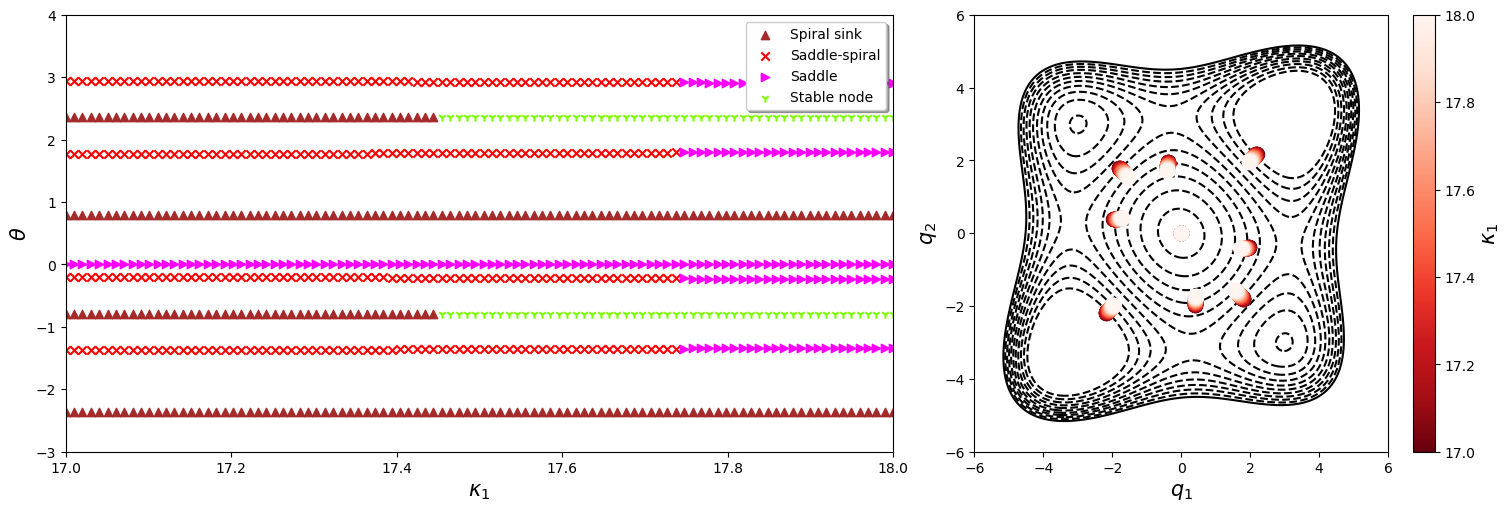

In [29]:
stb = ["Saddle", "Saddle-spiral", "Center", "Saddle-center", "Spiral source", "Spiral sink", "Unstable node", "Stable node", "Unclassified"]    ;
stb_marker = [">", "x", "*", "o", "s", "^" , "+", "1", "D"];
stb_color = ["magenta", "red",  "green", "orange", "purple", "brown", "blue", "lawngreen", "cyan"];
N_stb = length(stb);

fig = figure(figsize=(15, 5), layout="constrained");
gs = fig.add_gridspec(1,3);
element(i,j) = get(gs, (i,j)); # starts at 0 to N-1
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j);
font_l = 15
font_t = 13
stb_aux = ["Saddle", "Saddle-spiral", "Center", "Saddle-center", "Spiral source", "Spiral sink", "Unstable node", "Stable node", "Unclassified"]    ;


ax = fig.add_subplot(element(0,slice(0,2)));
for i in 1:length(ps)
    num_fp = count(x -> x != "", s_λs[i,:])

    if num_fp == 0
        continue
    end

    for j in 1:num_fp
        idx = findall(x -> x == s_λs[i,:][j], stb)[1]

        if s_λs[i,:][j] in stb_aux
            scatter(ps[i], θ1s[i,:][j], color=stb_color[idx], marker= stb_marker[idx],label= s_λs[i,:][j]);
            filter!(x -> x != s_λs[i,:][j], stb_aux)
            legend(fontsize=10, shadow=true, loc = "upper right");

        else
            scatter(ps[i], θ1s[i,:][j], color=stb_color[idx], marker= stb_marker[idx]);
        end
    end
end
ax.set_xlabel(L"κ_{1}",fontsize=font_l);
ax.set_ylabel(L"θ",fontsize=font_l);
ax.set_xlim(ps[1], ps[end])
ax.set_ylim(-3, 4)
#xscale("log");
#Second option of plot (single color)
ax = fig.add_subplot(element(0,2))
x_lim = 6
x = range(-x_lim,x_lim, length=1000);
y = range(-x_lim,x_lim, length=1000);
#Equivalent of meshgrid
coordinates_x = repeat(x', length(x), 1);
coordinates_y = repeat(y, 1, length(y));

#q1q2
q1, p1, q2, p2 = coordinates_x,0, coordinates_y,0;#q1,q2 
#q1, p1, q2, p2 = coordinates_x, coordinates_y,0.,0. #q1,p1

E_Contours = H_class([q1, p1, q2, p2], p);

Emin, Emax = -40, 0.
CS = contour(coordinates_x, coordinates_y, E_Contours, range(Emin, 2., length = 11), colors="black", zorder = 3);

for i in 1:N_p
    for j in 1:Int(Rs[i])
        scatter(All_roots[i][j][1], All_roots[i][j][3], c = ps[i], vmin=κ_min, vmax=κ_max, cmap ="Reds_r", marker = "o", s=100,zorder = 4)
    end
end
#cbar = colorbar(ticks=[0.7, 0.85, 1])
cbar = colorbar()
cbar.set_label(L"κ_{1}", fontsize=font_l);
#cbar.ax.set_yticklabels([0.1, 0.05, 0.001])
ax.set_xlabel(L"q_{1}",fontsize=font_l);
ax.set_ylabel(L"q_{2}",fontsize=font_l);


The shallower wells turn from Spiral sinks to stable nodes. They lost their imaginary parts in $\bold{\lambda}$. After some moment, the saddles-spirals around them also lost their complex components to become pure Saddles.  

In [30]:
N_p = 100; # Number of sweeping parameter
κ_min, κ_max = 18.5, 19.5
ps = range( κ_min,  κ_max, length = N_p); #range of the sweeping parameter 
θ1s = fill(NaN, N_p, 12); # angles
s_λs = fill("", N_p, 12); # stability labels
λs = [zeros(ComplexF64, 2,2)] #List of the eigenvalues
Rs = zeros(N_p); # number of roots
All_roots = [];
p = Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, γ  = 0., 1., 0., 5., 0., 1., 0., 5., 1.0;

for j in 1:N_p
    #println("j = $(j) and κ = $(ps[j])")
    #KPOs parameters
    parameters = Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, γ, ps[j], ps[j];

    roots_, λ, s_λ = Classical_open_KPOs.crit_energies(parameters, 6);

    R = length(roots_)
    Rs[j] = R
    θ1= zeros(R)
    #println(j)
    
    for i in 1:R
        if norm(roots_[i]) > 1e-5
            θ1[i] = atan(roots_[i][3], roots_[i][1])
        else
            θ1[i] = 0
        end
    end

    sorted_indices = sortperm(θ1)
    roots_, λ, s_λ = (roots_[sorted_indices]), λ[sorted_indices,:], s_λ[sorted_indices]

    θ1s[j,1:R] = θ1[sorted_indices]
    s_λs[j,1:R] = s_λ
    if j == 1
        λs[1] = λ
    else
        push!(λs, λ)
    end
    push!(All_roots, roots_)
end

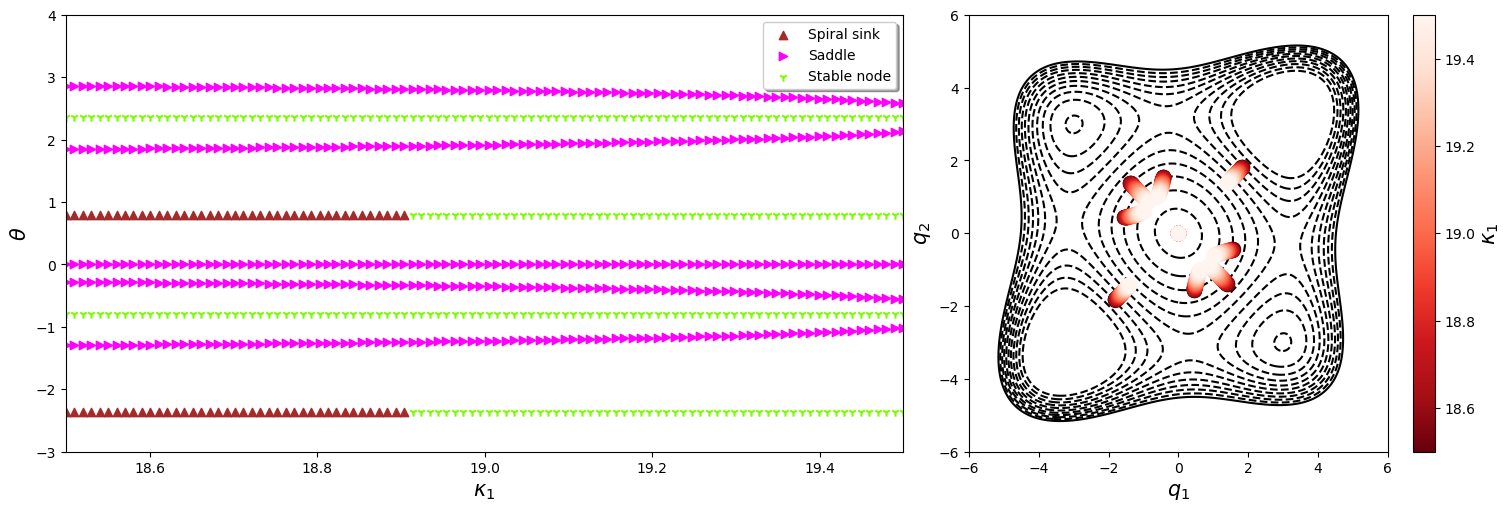

In [31]:
stb = ["Saddle", "Saddle-spiral", "Center", "Saddle-center", "Spiral source", "Spiral sink", "Unstable node", "Stable node", "Unclassified"]    ;
stb_marker = [">", "x", "*", "o", "s", "^" , "+", "1", "D"];
stb_color = ["magenta", "red",  "green", "orange", "purple", "brown", "blue", "lawngreen", "cyan"];
N_stb = length(stb);

fig = figure(figsize=(15, 5), layout="constrained");
gs = fig.add_gridspec(1,3);
element(i,j) = get(gs, (i,j)); # starts at 0 to N-1
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j);
font_l = 15
font_t = 13
stb_aux = ["Saddle", "Saddle-spiral", "Center", "Saddle-center", "Spiral source", "Spiral sink", "Unstable node", "Stable node", "Unclassified"]    ;


ax = fig.add_subplot(element(0,slice(0,2)));
for i in 1:length(ps)
    num_fp = count(x -> x != "", s_λs[i,:])

    if num_fp == 0
        continue
    end

    for j in 1:num_fp
        idx = findall(x -> x == s_λs[i,:][j], stb)[1]

        if s_λs[i,:][j] in stb_aux
            scatter(ps[i], θ1s[i,:][j], color=stb_color[idx], marker= stb_marker[idx],label= s_λs[i,:][j]);
            filter!(x -> x != s_λs[i,:][j], stb_aux)
            legend(fontsize=10, shadow=true, loc = "upper right");

        else
            scatter(ps[i], θ1s[i,:][j], color=stb_color[idx], marker= stb_marker[idx]);
        end
    end
end
ax.set_xlabel(L"κ_{1}",fontsize=font_l);
ax.set_ylabel(L"θ",fontsize=font_l);
ax.set_xlim(ps[1], ps[end])
ax.set_ylim(-3, 4)
#xscale("log");
#Second option of plot (single color)
ax = fig.add_subplot(element(0,2))
x_lim = 6
x = range(-x_lim,x_lim, length=1000);
y = range(-x_lim,x_lim, length=1000);
#Equivalent of meshgrid
coordinates_x = repeat(x', length(x), 1);
coordinates_y = repeat(y, 1, length(y));

#q1q2
q1, p1, q2, p2 = coordinates_x,0, coordinates_y,0;#q1,q2 
#q1, p1, q2, p2 = coordinates_x, coordinates_y,0.,0. #q1,p1

E_Contours = H_class([q1, p1, q2, p2], p);

Emin, Emax = -40, 0.
CS = contour(coordinates_x, coordinates_y, E_Contours, range(Emin, 2., length = 11), colors="black", zorder = 3);

for i in 1:N_p
    for j in 1:Int(Rs[i])
        scatter(All_roots[i][j][1], All_roots[i][j][3], c = ps[i], vmin=κ_min, vmax=κ_max, cmap ="Reds_r", marker = "o", s=100,zorder = 4)
    end
end
#cbar = colorbar(ticks=[0.7, 0.85, 1])
cbar = colorbar()
cbar.set_label(L"κ_{1}", fontsize=font_l);
#cbar.ax.set_yticklabels([0.1, 0.05, 0.001])
ax.set_xlabel(L"q_{1}",fontsize=font_l);
ax.set_ylabel(L"q_{2}",fontsize=font_l);


Increasing the coupling stregth, the deeper wells turn from Spiral sinks to stable nodes. They lost their imaginary parts in $\bold{\lambda}$.

In [44]:
N_p = 100; # Number of sweeping parameter
κ_min, κ_max = 19.5, 20.49
ps = range( κ_min,  κ_max, length = N_p); #range of the sweeping parameter 
θ1s = fill(NaN, N_p, 12); # angles
s_λs = fill("", N_p, 12); # stability labels
λs = [zeros(ComplexF64, 2,2)] #List of the eigenvalues
Rs = zeros(N_p); # number of roots
All_roots = [];
p = Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, γ  = 0., 1., 0., 5., 0., 1., 0., 5., 1.0;

for j in 1:N_p
    println("j = $(j) and κ = $(ps[j])")
    #KPOs parameters
    parameters = Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, γ, ps[j], ps[j];

    roots_, λ, s_λ = Classical_open_KPOs.crit_energies(parameters, 6);

    R = length(roots_)
    Rs[j] = R
    θ1= zeros(R)
    #println(j)
    
    for i in 1:R
        if norm(roots_[i]) > 1e-5
            θ1[i] = atan(roots_[i][3], roots_[i][1])
        else
            θ1[i] = 0
        end
    end

    sorted_indices = sortperm(θ1)
    roots_, λ, s_λ = (roots_[sorted_indices]), λ[sorted_indices,:], s_λ[sorted_indices]

    θ1s[j,1:R] = θ1[sorted_indices]
    s_λs[j,1:R] = s_λ
    if j == 1
        λs[1] = λ
    else
        push!(λs, λ)
    end
    push!(All_roots, roots_)
end

j = 1 and κ = 19.5
j = 2 and κ = 19.51
j = 3 and κ = 19.52
j = 4 and κ = 19.53
j = 5 and κ = 19.54
j = 6 and κ = 19.55
j = 7 and κ = 19.56
j = 8 and κ = 19.57
j = 9 and κ = 19.58
j = 10 and κ = 19.59
j = 11 and κ = 19.6
j = 12 and κ = 19.61
j = 13 and κ = 19.62
j = 14 and κ = 19.63
j = 15 and κ = 19.64
j = 16 and κ = 19.65
j = 17 and κ = 19.66
j = 18 and κ = 19.67
j = 19 and κ = 19.68
j = 20 and κ = 19.69
j = 21 and κ = 19.7
j = 22 and κ = 19.71
j = 23 and κ = 19.72
j = 24 and κ = 19.73
j = 25 and κ = 19.74
j = 26 and κ = 19.75
j = 27 and κ = 19.76
j = 28 and κ = 19.77
j = 29 and κ = 19.78
j = 30 and κ = 19.79
j = 31 and κ = 19.8
j = 32 and κ = 19.81
j = 33 and κ = 19.82
j = 34 and κ = 19.83
j = 35 and κ = 19.84
j = 36 and κ = 19.85
j = 37 and κ = 19.86
j = 38 and κ = 19.87
j = 39 and κ = 19.88


LoadError: BoundsError: attempt to access 100×12 Matrix{Float64} at index [39, 1:37]

Error at κ = 19.88, it has more roots than 12. 

In [45]:
N_p = 100; # Number of sweeping parameter
κ_min, κ_max = 19.5, 20.49
ps = range( κ_min,  κ_max, length = N_p); #range of the sweeping parameter 
θ1s = fill(NaN, N_p, 12); # angles
s_λs = fill("", N_p, 12); # stability labels
λs = [zeros(ComplexF64, 2,2)] #List of the eigenvalues
Rs = zeros(N_p); # number of roots
All_roots = [];
p = Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, γ  = 0., 1., 0., 5., 0., 1., 0., 5., 1.0;

j = 39
    println("j = $(j) and κ = $(ps[j])")
    #KPOs parameters
    parameters = Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, γ, ps[j], ps[j];

    roots_, λ, s_λ = Classical_open_KPOs.crit_energies(parameters, 6);

    R = length(roots_)
    println("roots found: $(R)")

j = 39 and κ = 19.88
roots found: 37


In [46]:
#Testing roots
for i in 1:R
    println(norm(EqM_2(roots_[i], parameters)))
end

LoadError: UndefVarError: `EqM_2` not defined in `Main`
Hint: It looks like two or more modules export different bindings with this name, resulting in ambiguity. Try explicitly importing it from a particular module, or qualifying the name with the module it should come from.